In [ ]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# importando dados
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/uau/house_sales.csv')
data.head()

,price,num_bed,num_bath,size_house,size_lot,num_floors,is_waterfront,condition,size_basement,year_built,renovation_date,zip,latitude,longitude,avg_size_neighbor_houses,avg_size_neighbor_lot
0,221900,3,1.00,1180,5650,1.0,0,3,0,1955,0,98178,47.511234,-122.256775,1340,5650
1,538000,3,2.25,2570,7242,2.0,0,3,400,1951,1991,98125,47.721023,-122.318862,1690,7639
2,180000,2,1.00,770,10000,1.0,0,3,0,1933,0,98028,47.737927,-122.233196,2720,8062
3,604000,4,3.00,1960,5000,1.0,0,5,910,1965,0,98136,47.520820,-122.393185,1360,5000
4,510000,3,2.00,1680,8080,1.0,0,3,0,1987,0,98074,47.616812,-122.044901,1800,7503


<function seaborn.utils.despine>

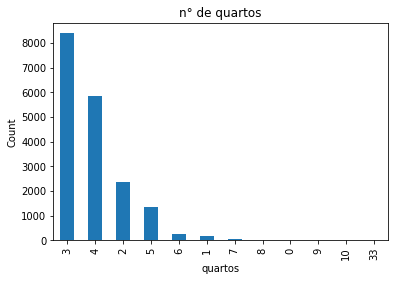

In [ ]:
# quantidade de quartos é um fator muito importante para estimar um valor
data['num_bed'].value_counts().plot(kind='bar')
plt.title('n° de quartos')
plt.xlabel('quartos')
plt.ylabel('Count')
sns.despine

## **A moda dos quartos é 3, é o mais comum entre as casas**

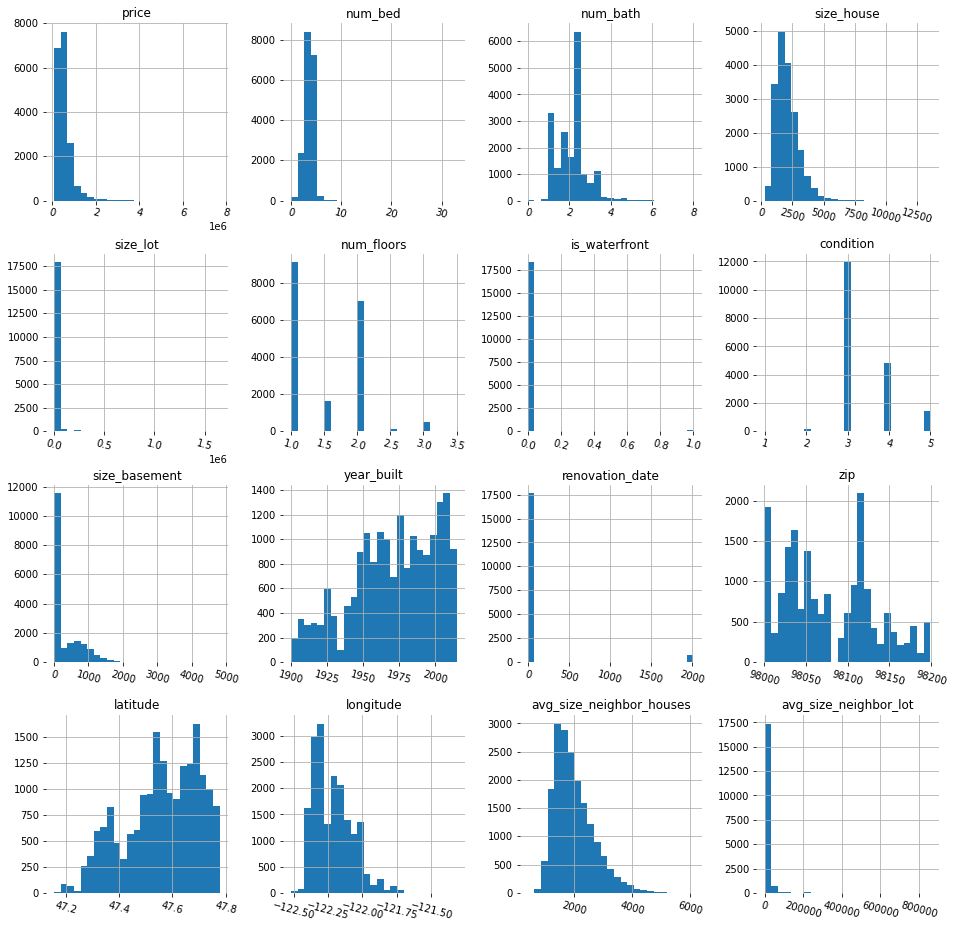

In [ ]:
df=data[['price', 'num_bed', 'num_bath', 'size_house',
    'size_lot', 'num_floors', 'is_waterfront', 'condition', 'size_basement',
    'year_built', 'renovation_date', 'zip', 'latitude', 'longitude',
    'avg_size_neighbor_houses', 'avg_size_neighbor_lot']]
h = df.hist(bins=25,figsize=(16,16),xlabelsize='10',ylabelsize='10',xrot=-15)
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];
# Filtro de warnigns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

# **Com esses histogramas podemos ver melhor onde os dados se concentram para cada categoria, não aparentam seguir uma distribuição normal, pensei em usar a distribuição Johnson mas como não ficou muito claro para mim a metodologia optei por utilizar**

In [ ]:
# Definindo a função para calcular R^2
def adjustedR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import cross_val_score


# Esse modelo construi com base no livro 'Basics of Linear Algebra for Machine Learning' de Jason Brownlee e auxílio do livro 'Machine Learning with Python Cookbook' do Chris Albon  
evaluation = pd.DataFrame({'Model': [],
                           'Details':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'R-squared (training)':[],
                           'Adjusted R-squared (training)':[],
                           'R-squared (test)':[],
                           'Adjusted R-squared (test)':[],
                           '5-Fold Cross Validation':[]})

train_data,test_data = train_test_split(df,train_size = 0.8,random_state=3)

lr = linear_model.LinearRegression()
X_train = np.array(train_data['size_house'], dtype=pd.Series).reshape(-1,1)
y_train = np.array(train_data['price'], dtype=pd.Series)
lr.fit(X_train,y_train)

X_test = np.array(test_data['size_house'], dtype=pd.Series).reshape(-1,1)
y_test = np.array(test_data['price'], dtype=pd.Series)

pred = lr.predict(X_test)
rmsesm = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
rtrsm = float(format(lr.score(X_train, y_train),'.3f'))
rtesm = float(format(lr.score(X_test, y_test),'.3f'))
cv = float(format(cross_val_score(lr,df[['size_house']],df['price'],cv=5).mean(),'.3f'))

print ("Average Price for Test Data: {:.3f}".format(y_test.mean()))
print('Intercept: {}'.format(lr.intercept_))
print('Coefficient: {}'.format(lr.coef_))

r = evaluation.shape[0]
evaluation.loc[r] = ['Simple Linear Regression','-',rmsesm,rtrsm,'-',rtesm,'-',cv]
evaluation

Average Price for Test Data: 532034.458
Intercept: -54861.00341576582
Coefficient: [287.75532801]


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
0,Simple Linear Regression,-,255005.045,0.501,-,0.483,-,0.496


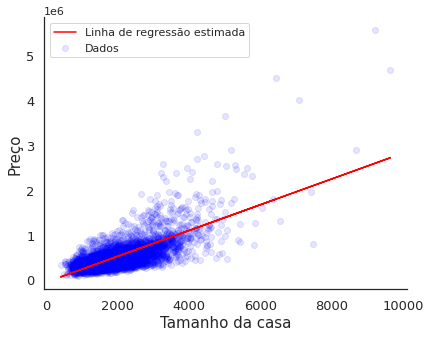

In [ ]:
# Vamos visualizar
sns.set(style="white", font_scale=1)
plt.figure(figsize=(6.5,5))
plt.scatter(X_test,y_test,color='blue',label="Dados", alpha=.1)
plt.plot(X_test,lr.predict(X_test),color="red",label="Linha de regressão estimada")
plt.xlabel("Tamanho da casa", fontsize=15)
plt.ylabel("Preço", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# **O modelo simples ficou muito pobre, irei tentar com a regressão múltipla**

In [ ]:
# Criei um novo dataframe somente para esse modelo
df_dm=df.copy()
df_dm.describe()

train_data_dm,test_data_dm = train_test_split(df_dm,train_size = 0.8,random_state=3)

features = ['num_bed','num_bath','size_house','size_lot','num_floors','zip']
complex_model_1 = linear_model.LinearRegression()
complex_model_1.fit(train_data_dm[features],train_data_dm['price'])

print('Intercept: {}'.format(complex_model_1.intercept_))
print('Coefficients: {}'.format(complex_model_1.coef_))

pred = complex_model_1.predict(test_data_dm[features])
rmsecm = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred)),'.3f'))
rtrcm = float(format(complex_model_1.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm = float(format(adjustedR2(complex_model_1.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm = float(format(complex_model_1.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm = float(format(adjustedR2(complex_model_1.score(test_data_dm[features],test_data['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv = float(format(cross_val_score(complex_model_1,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Multiple Regression-1','selected features',rmsecm,rtrcm,artrcm,rtecm,artecm,cv]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

Intercept: -59297336.37627714
Coefficients: [-5.75574978e+04  1.38412533e+04  3.21457962e+02 -2.40764664e-01
 -3.13088690e+03  6.05082545e+02]


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
1,Multiple Regression-1,selected features,248977.833,0.523,0.523,0.507,0.506,0.517
0,Simple Linear Regression,-,255005.045,0.501,-,0.483,-,0.496


In [ ]:
# Irei adicionar mais features

features = ['num_bed','num_bath','size_house','size_lot','num_floors','zip','is_waterfront','condition', 'size_basement']
complex_model_2 = linear_model.LinearRegression()
complex_model_2.fit(train_data_dm[features],train_data_dm['price'])

print('Intercept: {}'.format(complex_model_2.intercept_))
print('Coefficients: {}'.format(complex_model_2.coef_))

pred = complex_model_2.predict(test_data_dm[features])
rmsecm = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred)),'.3f'))
rtrcm = float(format(complex_model_2.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm = float(format(adjustedR2(complex_model_2.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm = float(format(complex_model_2.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm = float(format(adjustedR2(complex_model_2.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv = float(format(cross_val_score(complex_model_2,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Multiple Regression-2','selected features',rmsecm,rtrcm,artrcm,rtecm,artecm,cv]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

Intercept: -55003349.818282224
Coefficients: [-5.36747618e+04  1.86002527e+04  3.07293315e+02 -2.42729423e-01
  1.19430341e+04  5.59195641e+02  8.32968651e+05  5.46078864e+04
 -9.53835293e+00]


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
2,Multiple Regression-2,selected features,244427.914,0.570,0.57,0.525,0.524,0.556
1,Multiple Regression-1,selected features,248977.833,0.523,0.523,0.507,0.506,0.517
0,Simple Linear Regression,-,255005.045,0.501,-,0.483,-,0.496


In [ ]:
features = ['num_bed','num_bath','size_house','size_lot','num_floors','zip','is_waterfront','condition', 'size_basement', 'latitude','longitude','avg_size_neighbor_houses','avg_size_neighbor_lot']
complex_model_3 = linear_model.LinearRegression()
complex_model_3.fit(train_data[features],train_data['price'])

print('Intercept: {}'.format(complex_model_3.intercept_))
print('Coefficients: {}'.format(complex_model_3.coef_))

pred = complex_model_3.predict(test_data[features])
rmsecm = float(format(np.sqrt(metrics.mean_squared_error(test_data['price'],pred)),'.3f'))
rtrcm = float(format(complex_model_3.score(train_data[features],train_data['price']),'.3f'))
artrcm = float(format(adjustedR2(complex_model_3.score(train_data[features],train_data['price']),train_data.shape[0],len(features)),'.3f'))
rtecm = float(format(complex_model_3.score(test_data[features],test_data['price']),'.3f'))
artecm = float(format(adjustedR2(complex_model_3.score(test_data[features],test_data['price']),test_data.shape[0],len(features)),'.3f'))
cv = float(format(cross_val_score(complex_model_3,df[features],df['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Multiple Regression-3','all features, no preprocessing',rmsecm,rtrcm,artrcm,rtecm,artecm,cv]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

Intercept: -47588657.32633616
Coefficients: [-4.58128664e+04  2.53829528e+04  2.64037138e+02  3.33496890e-01
 -2.52711161e+03 -3.99283545e+02  8.44688175e+05  5.14370462e+04
 -4.11185333e+01  7.03045083e+05 -4.34461740e+05  7.29572783e+01
 -5.10333152e-01]


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
3,Multiple Regression-3,"all features, no preprocessing",218380.452,0.654,0.654,0.621,0.619,0.644
2,Multiple Regression-2,selected features,244427.914,0.570,0.57,0.525,0.524,0.556
1,Multiple Regression-1,selected features,248977.833,0.523,0.523,0.507,0.506,0.517
0,Simple Linear Regression,-,255005.045,0.501,-,0.483,-,0.496


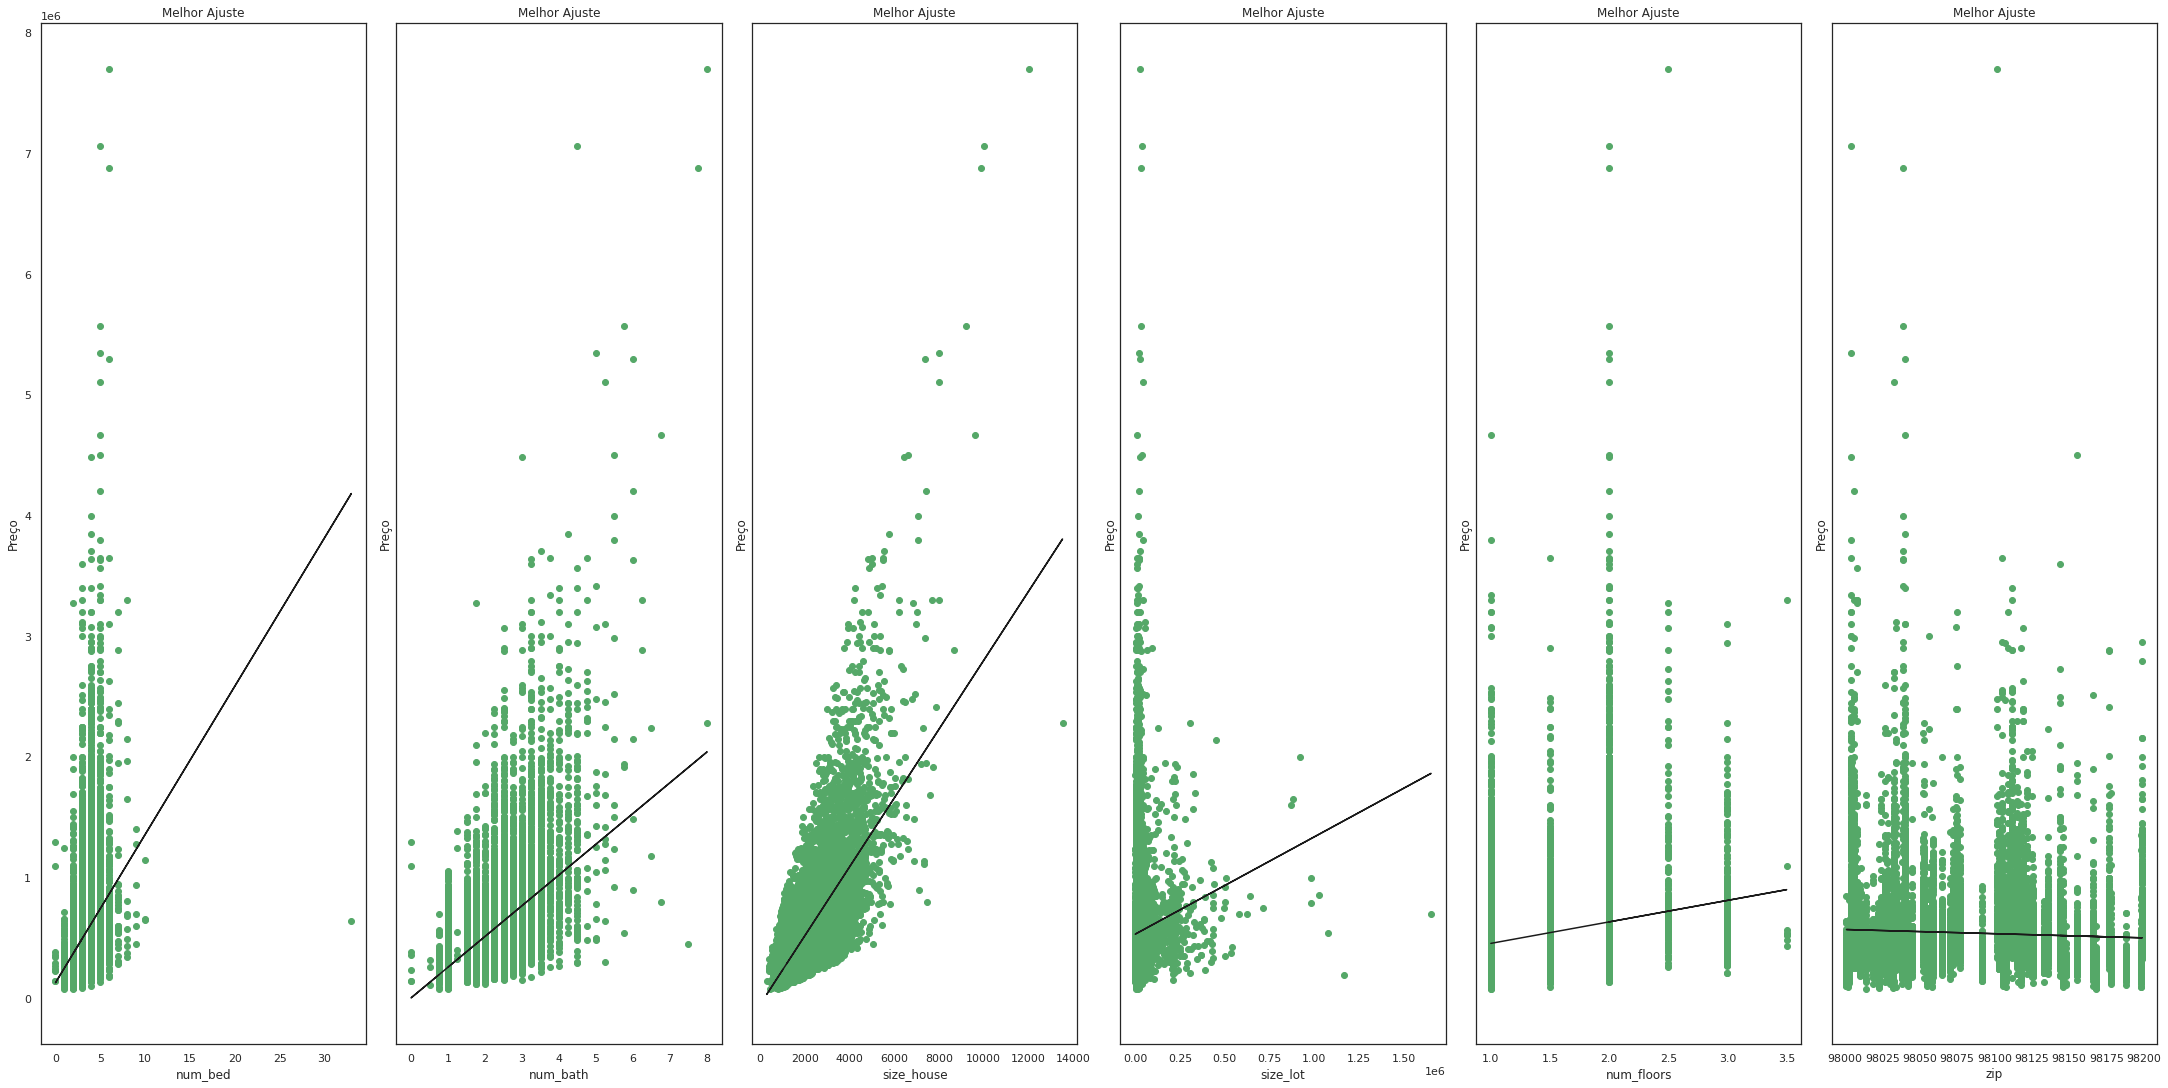

In [ ]:
# Plot Multiple Regression-1	
train_copy = train[['num_bed','num_bath','size_house','size_lot','num_floors','zip']]
train_copy =pd.get_dummies(train_copy)
train_copy=train_copy.fillna(0)
linear_regr_test = LinearRegression()

fig, axes = plt.subplots(1,len(train_copy.columns.values),sharey=True,constrained_layout=True,figsize=(30,15))

for i,e in enumerate(train_copy.columns):
  linear_regr_test.fit(train_copy[e].values[:,np.newaxis], y.values)
  axes[i].set_title("Melhor Ajuste")
  axes[i].set_xlabel(str(e))
  axes[i].set_ylabel('Preço')
  axes[i].scatter(train_copy[e].values[:,np.newaxis], y,color='g')
  axes[i].plot(train_copy[e].values[:,np.newaxis], 
  linear_regr_test.predict(train_copy[e].values[:,np.newaxis]),color='k')



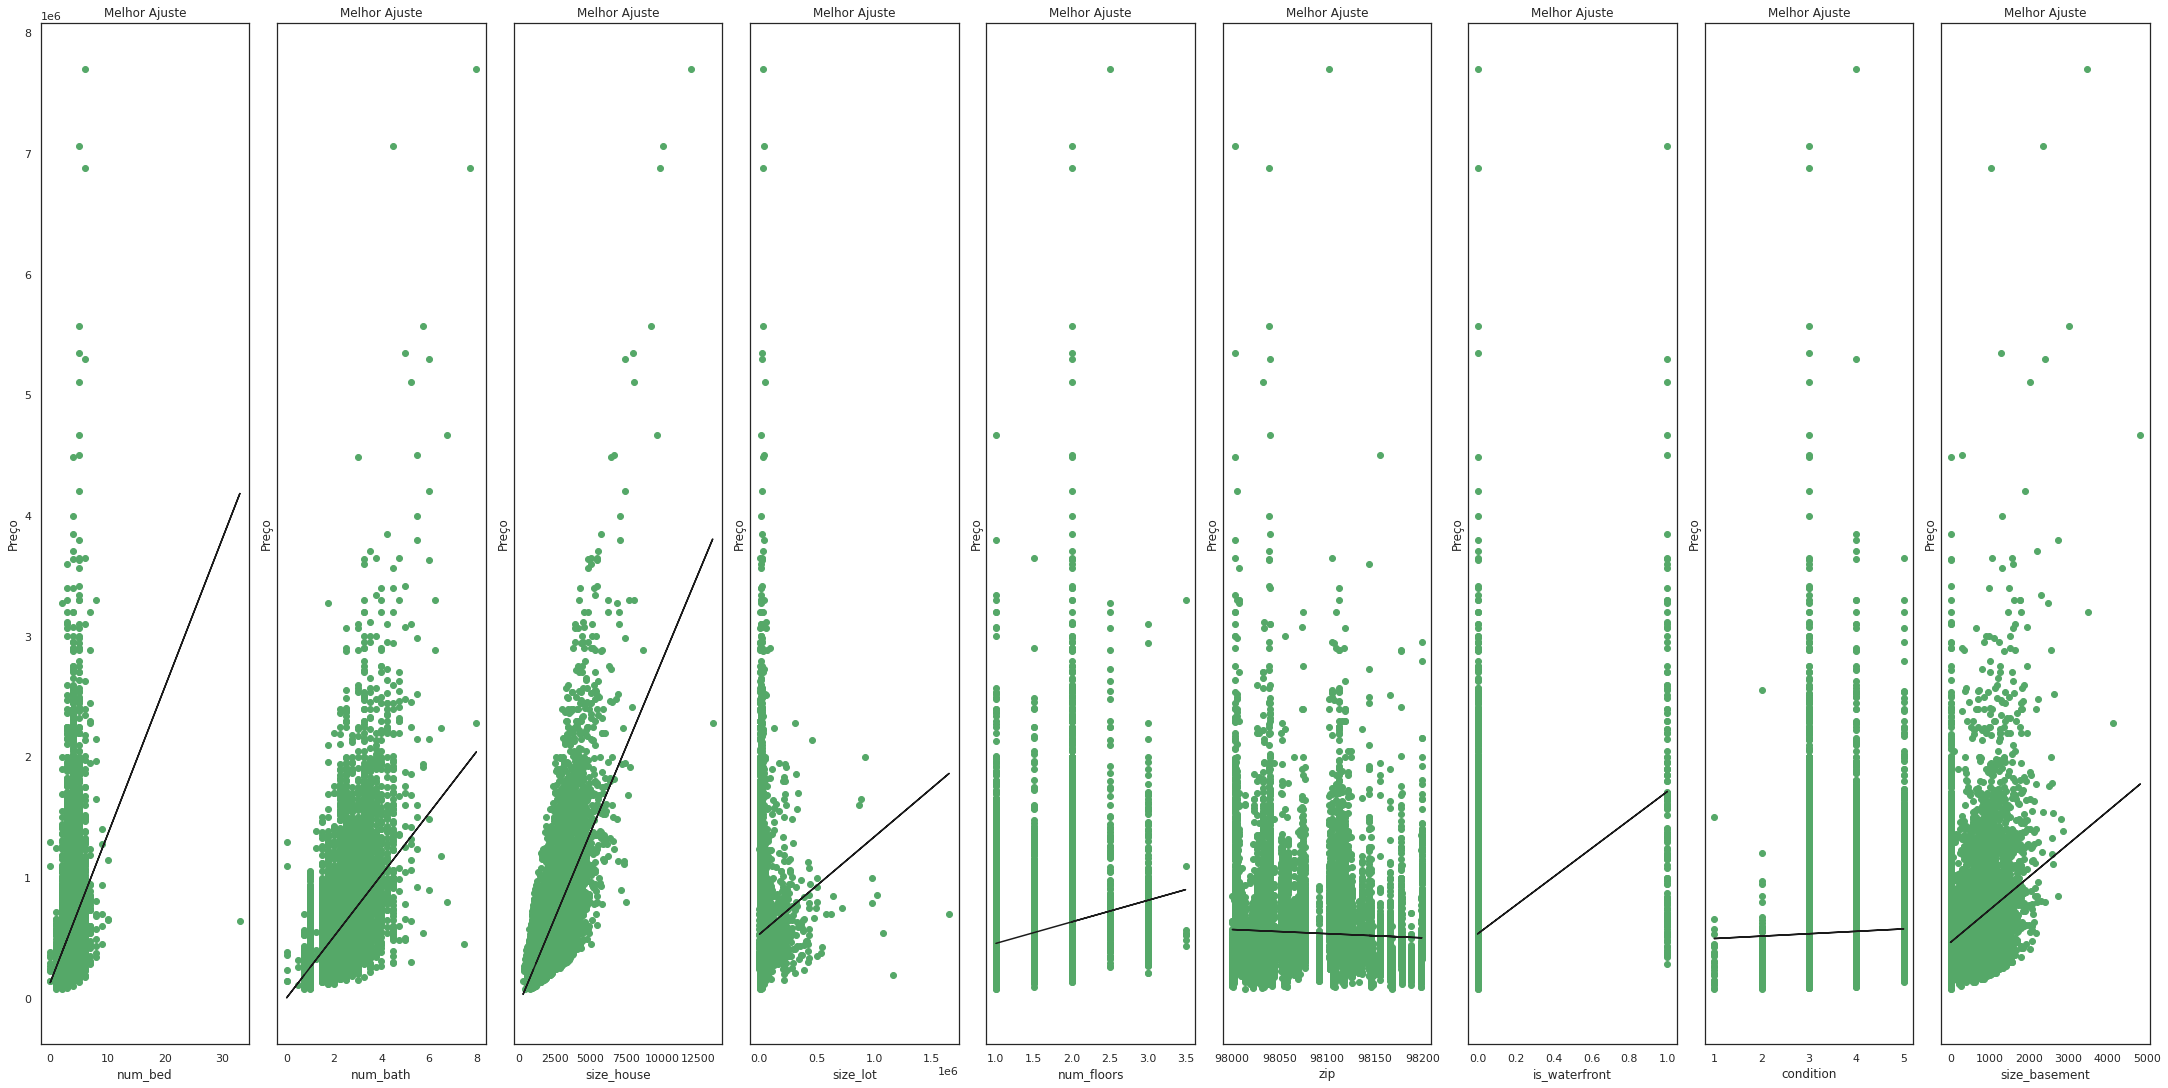

In [ ]:
# Plot Multiple Regression-2
train_copy = train[['num_bed','num_bath','size_house','size_lot','num_floors','zip','is_waterfront','condition', 'size_basement']]
train_copy =pd.get_dummies(train_copy)
train_copy=train_copy.fillna(0)
linear_regr_test = LinearRegression()

fig, axes = plt.subplots(1,len(train_copy.columns.values),sharey=True,constrained_layout=True,figsize=(30,15))

for i,e in enumerate(train_copy.columns):
  linear_regr_test.fit(train_copy[e].values[:,np.newaxis], y.values)
  axes[i].set_title("Melhor Ajuste")
  axes[i].set_xlabel(str(e))
  axes[i].set_ylabel('Preço')
  axes[i].scatter(train_copy[e].values[:,np.newaxis], y,color='g')
  axes[i].plot(train_copy[e].values[:,np.newaxis], 
  linear_regr_test.predict(train_copy[e].values[:,np.newaxis]),color='k')

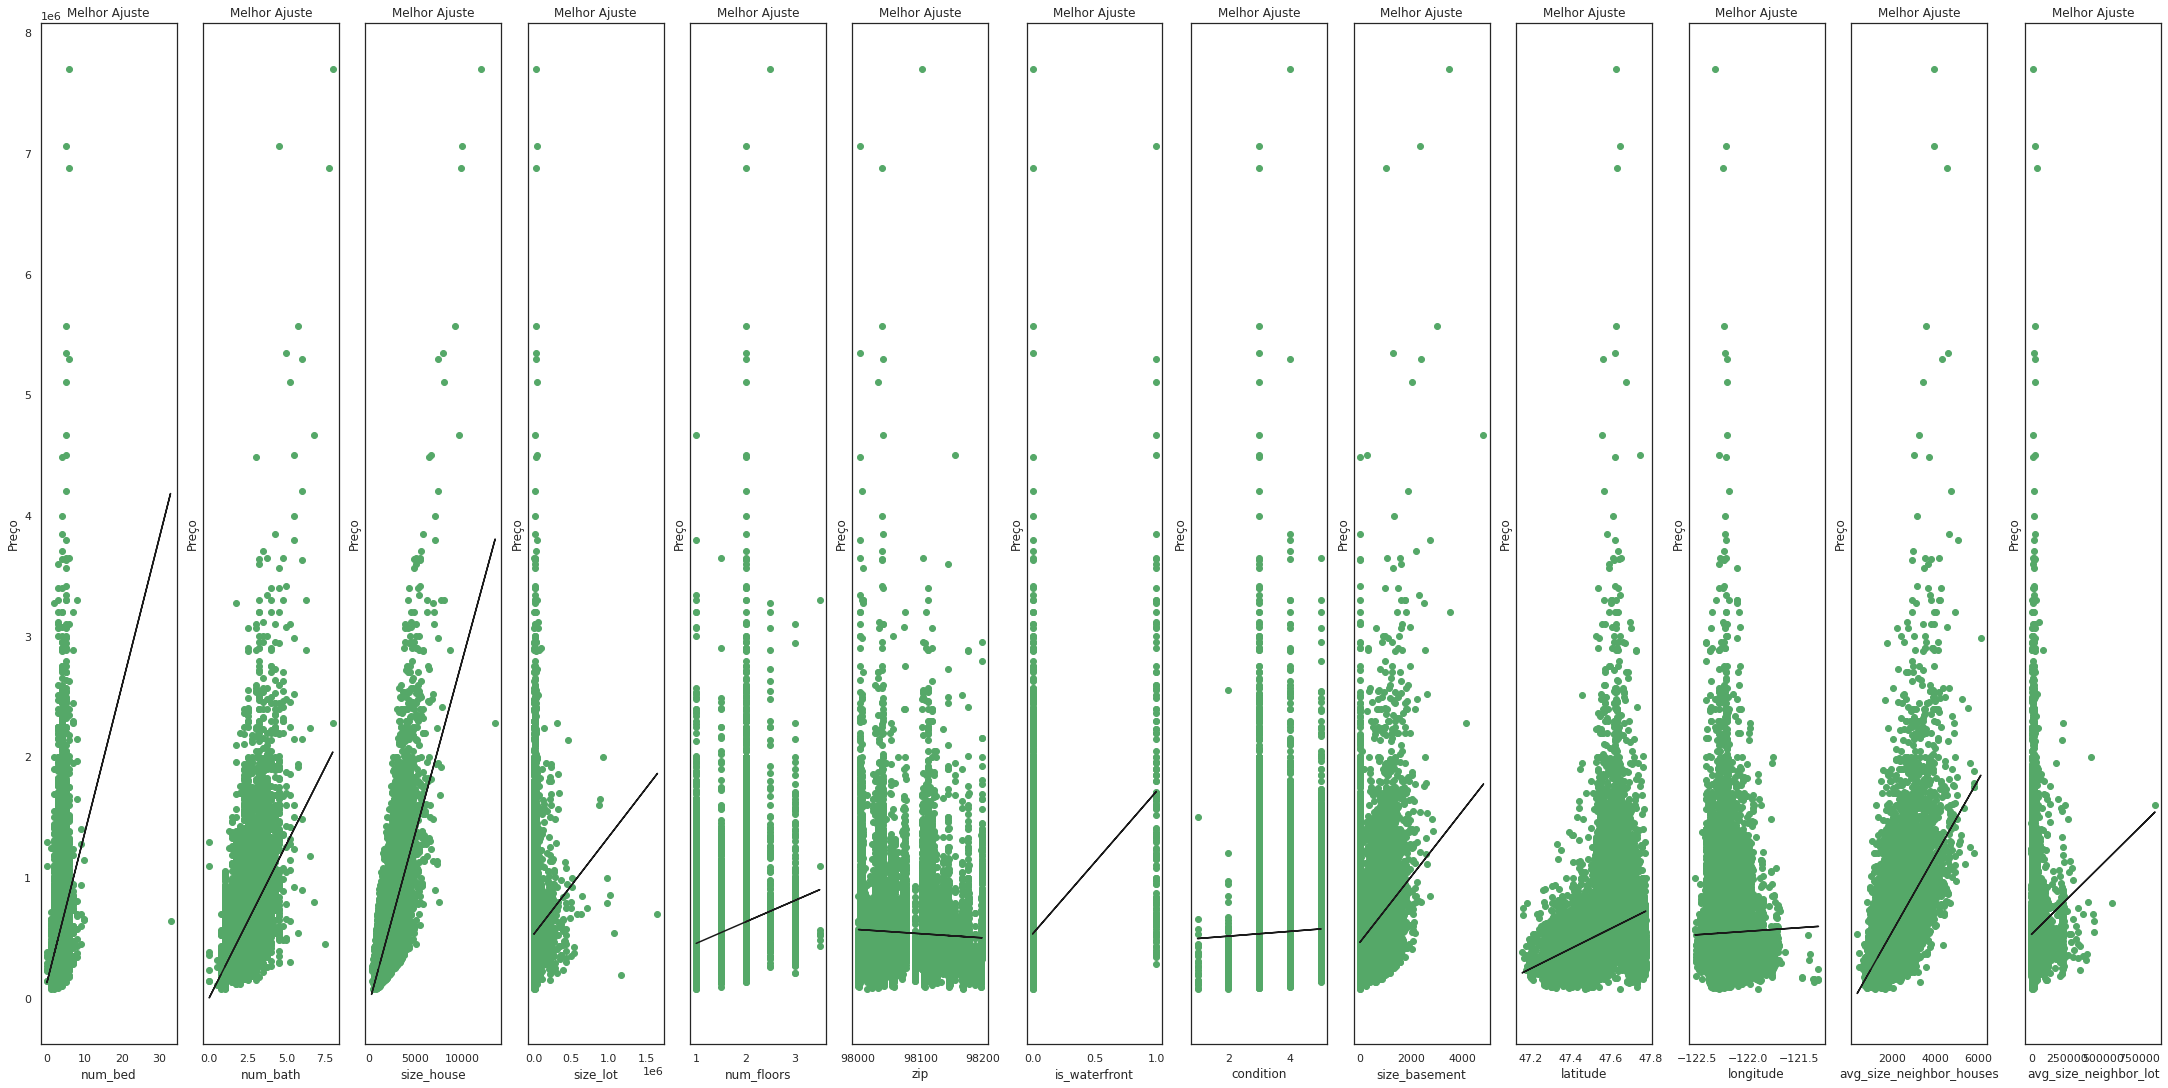

In [ ]:
# Plot Multiple Regression-3
train_copy = train[['num_bed','num_bath','size_house','size_lot','num_floors','zip','is_waterfront','condition', 'size_basement', 'latitude','longitude','avg_size_neighbor_houses','avg_size_neighbor_lot']]
train_copy =pd.get_dummies(train_copy)
train_copy=train_copy.fillna(0)
linear_regr_test = LinearRegression()

fig, axes = plt.subplots(1,len(train_copy.columns.values),sharey=True,constrained_layout=True,figsize=(30,15))

for i,e in enumerate(train_copy.columns):
  linear_regr_test.fit(train_copy[e].values[:,np.newaxis], y.values)
  axes[i].set_title("Melhor Ajuste")
  axes[i].set_xlabel(str(e))
  axes[i].set_ylabel('Preço')
  axes[i].scatter(train_copy[e].values[:,np.newaxis], y,color='g')
  axes[i].plot(train_copy[e].values[:,np.newaxis], 
  linear_regr_test.predict(train_copy[e].values[:,np.newaxis]),color='k')